In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.segmentation import fcn_resnet50
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np

class CIFAR10Segmentation(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        
        # Create a synthetic mask with the same label for the whole image
        # The mask needs to be a single-channel image where each pixel's value is the class label
        mask = Image.fromarray(np.full((image.size[1], image.size[2]), label, dtype=np.uint8))

        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            mask = self.target_transform(mask)
        
        return image, mask


# Define transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

target_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)
])

# Using the CIFAR10 dataset for both images and synthetic segmentation masks
cifar10_train = CIFAR10Segmentation(root='../../../Practice/ai_0009_cnn_CIFAR10/data', train=True, transform=transform, target_transform=target_transform, download=True)

# Create the DataLoader
dataloader = DataLoader(cifar10_train, batch_size=2, shuffle=True)

# Load a pre-trained FCN model
model = fcn_resnet50(pretrained=False)

# Replace the classifier with a new one (assuming num_classes is the number of your target classes)
num_classes = 10  # CIFAR10 has 10 classes
model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Choose an appropriate number of epochs for your training
for epoch in range(num_epochs):
    model.train()
    for images, masks in dataloader:
        images = images.to(device)
        masks = torch.squeeze(masks, 1).to(device)  # Remove the channel dimension

        # Forward pass
        outputs = model(images)['out']
        loss = nn.functional.cross_entropy(outputs, masks.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), 'fcn_resnet50_cifar10.pth')

# Note: This code is for demonstration purposes and the CIFAR10 is not a segmentation dataset.
# The synthetic masks used here are for demonstration and do not correspond to real segmentation masks.


Files already downloaded and verified


TypeError: Unexpected type <class 'int'>

In [4]:
import pixellib
from pixellib.semantic import semantic_segmentation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization



# Load a pre-trained model
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("deeplabv3_xception65_ade20k.h5")

# Perform segmentation on an image
segment_image.segmentAsAde20k("a.jpg", output_image_name="image_new.jpg")

# Display the segmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('image_new.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


ImportError: cannot import name 'BatchNormalization' from 'tensorflow.python.keras.layers' (/Users/owo/anaconda3/envs/auto/lib/python3.11/site-packages/tensorflow/python/keras/layers/__init__.py)

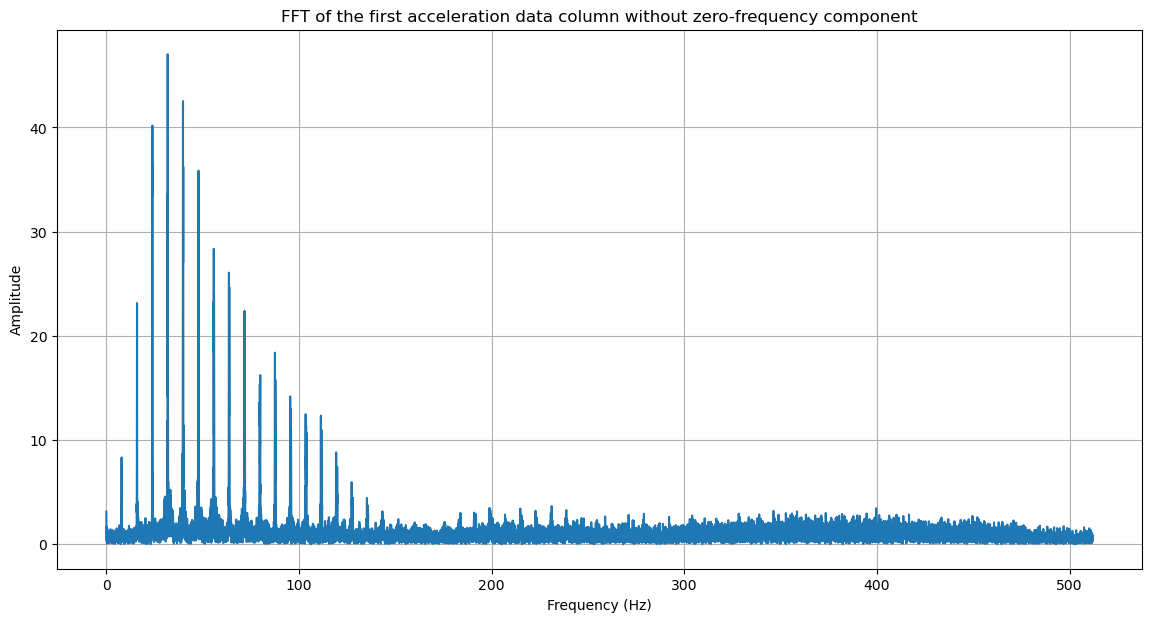

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data, skipping the initial non-numeric headers and convert all to numeric
df = pd.read_excel('Dataset_acceleration.xlsx', skiprows=[0, 1])
df_cleaned = df.drop([0])  # Drop the row with 'Real'
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')  # Convert all to numeric
df_cleaned = df_cleaned.dropna(axis=1, how='all')  # Drop any columns that are all NaN

# Use the first 's' column for time data to determine the sampling rate
time_step = df_cleaned['s'].diff().mode()[0]

# Perform the FFT on the first acceleration data column
accel_data = df_cleaned['m/s^2'].values

# Number of sample points
N = len(accel_data)

# FFT computation
fft_values = np.fft.fft(accel_data)
fft_freq = np.fft.fftfreq(N, d=time_step)

# Taking the positive half of the spectrum and excluding the zero-frequency component
positive_freqs = fft_freq[:N//2][1:]  # Exclude the first element which is zero frequency
positive_values = 2.0/N * np.abs(fft_values[:N//2])[1:]  # Exclude the first element

# Plot the FFT without the zero-frequency component
plt.figure(figsize=(14, 7))
plt.plot(positive_freqs, positive_values)
plt.title('FFT of the first acceleration data column without zero-frequency component')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
